![EDA](http://github.com/meghazavar/goodreads_book_recommender/blob/master/images/what_is_eda.png")

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task

# Import packages

In [2]:
import pandas as pd 
import chart_studio.plotly as py 
import plotly.graph_objs as go 
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from betterreads import client
#gc = client.GoodreadsClient('zIHHGGHATvYay6dTTZ1AqA', 'xFiCr7PBabSezd7zpXhqNyvsIDFfoX4ftC6Pww7v2g')


# Import books review data

In [3]:
books = pd.read_csv('../data/books.csv')
books.head(1)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,num_pages,is_ebook
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"Could you survive on your own, in the wild, wi...",374.0,False


In [4]:
books.shape

(10000, 26)

# High level glance at Data

### Data dictionary

|column   |type   | description  |
|---|---|---|
|  bookID | int64  |  book dequence identifier | 
|  title | object  |  Title of the book | 
|  authors | object  | Authors of the book  | 
|  isbn |  object |   | 
|   isbn13| object  |   |  
|  language_code | object  | primary language of the book  |
| num_pages  | object  ||Number of pages the book contains   |
| ratings_count  | int64 |Total number of ratings book received   |
| text_reviews_count  | int64  |  total number of written text reviews book received | 
|average_rating |object | average rating of the book |


In [30]:
books.dtypes

goodreads_book_id              int64
authors                       object
original_publication_year    float64
original_title                object
title                         object
average_rating               float64
ratings_count                  int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
dtype: object

### Basic dataset cleaning

In [9]:
books.isna().sum()

goodreads_book_id              0
authors                        0
original_publication_year     21
original_title               585
title                          0
average_rating                 0
ratings_count                  0
ratings_1                      0
ratings_2                      0
ratings_3                      0
ratings_4                      0
ratings_5                      0
description                  115
num_pages                     10
is_ebook                      10
dtype: int64

In [5]:
len(books[books['original_title'] ==books['title']]),
len(books[books['original_title'] !=books['title']])

6015

In [6]:
books['title'].value_counts()

Selected Poems                                                                4
Stone Soup                                                                    3
Invisible                                                                     2
The Pact                                                                      2
Arcadia                                                                       2
                                                                             ..
The Forge of God (Forge of God, #1)                                           1
Cry Wolf (Alpha & Omega, #1)                                                  1
Exodus                                                                        1
Caps for Sale: A Tale of a Peddler, Some Monkeys and Their Monkey Business    1
Entice (Need, #3)                                                             1
Name: title, Length: 9964, dtype: int64

In [7]:
#Drop columns that are not relevant for the recommender
#Dropping the last corrupted columns which has only handful of values
books = books.drop(['book_id','best_book_id','work_id','isbn13','language_code','isbn',
                    'books_count','work_ratings_count','work_text_reviews_count',
                    'image_url','small_image_url'], axis =1)

In [8]:
# Dropping the 5 rowes which has average rating as non-integer value
books= books[~books['average_rating'].isna()]
books['average_rating'] =  pd.to_numeric(books['average_rating'],errors='coerce')
books['average_rating'].dtype

dtype('float64')

In [ ]:
# renaming the. column so that naming style is consistent with other column names
books.rename(columns ={'# num_pages' : 'num_pages'}, inplace=True)
books['num_pages']=  pd.to_numeric(books['num_pages'], errors='coerce')

### Are the books unique ?

we have books unique isbn numbers  but  they have similar titles.
I am little wary of this data set now. It might  be a good  for proof of concept but  we may need to get cleaner data.

In [ ]:
#books_with_same_isbn =(books['isbn'].value_counts() >1) ==True
#len(books_with_same_isbn.index [books_with_same_isbn >1])

In [48]:
books_with_same_title = (books['title'].value_counts()  )
len(books_with_same_title.index[books_with_same_title >1])

0

In [7]:
len(books[books['authors'].str.contains('J.K. Rowling')])

27

In [47]:
#https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html
#De-duplicating the  records as we only care about title and content of the book , 

dup_books =books_with_same_title.index[books_with_same_title >1]
dup_book_df = books[books['title'].isin(dup_books)]

books = books.groupby('title').agg(
                             {'authors':'first', 
                              'average_rating':'mean',
                              'ratings_count': 'sum'
                              #'num_pages':'first'
                              }).reset_index()

### Average length of books?

In [401]:
print(f" confirming we have no  Nans {books['average_rating'].isnull().sum()}")
print(f"** we have books with zeros pages {len(books[books['num_pages'] ==0])}")

 confirming we have no  Nans 5
** we have books with zeros pages 85


In [402]:
def plot_distribution(column, title,xlabel,xstart,x_end,stepsize, bins =50):
    plt.figure(figsize=(16,20))
    plt.hist(books[column], bins)
    plt.gca().set(title='Most Books are 150-400 pages', ylabel='Count of books');
    plt.xlim(xstart,x_end)
    plt.xticks(np.arange(xstart, x_end, step=stepsize));
    plt.axvline(books['num_pages'].mean(), color='r',label ="average length")

/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



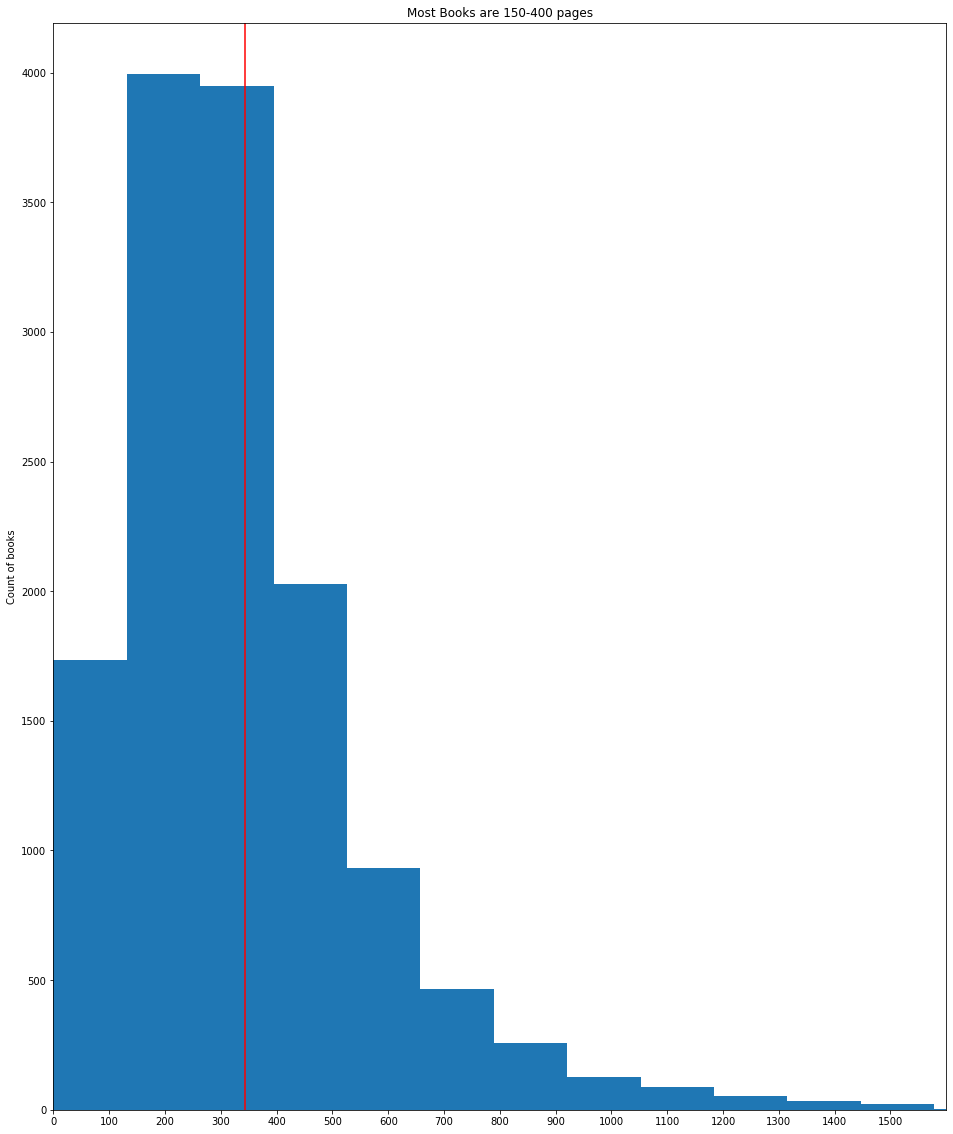

In [403]:
plot_distribution('num_pages',"length in pages",'Average lenth of a book is around 350 pages',0,1600,100)

In [8]:
layout = go.Layout(title="Distribution Number of pages for the books" , 
                   xaxis=dict(title="" ), 
                   yaxis=dict(title="Number of pages" )) 
fig = go.Figure(layout=layout)
# Use x instead of y argument for horizontal plot
fig.add_trace(go.Box(y=books['num_pages'],name='books',boxmean='sd'))
fig.show();

KeyError: 'num_pages'

### Do we have enough book ratings?

In [405]:
def reviewer_category(ratings_count):
    if ratings_count <10 :
        return('<10')
    elif ratings_count < 100:
        return('11-100')
    elif ratings_count <= 1000:
        return('101-1000')
    else:
         return('>1000')
books['ratings_weight'] =books['ratings_count'].map(reviewer_category)
books['ratings_weight'].value_counts()

>1000       6059
101-1000    3941
11-100      2736
<10          983
Name: ratings_weight, dtype: int64

Text(0.5, 1.0, 'Do we have enough people rate the books ?')

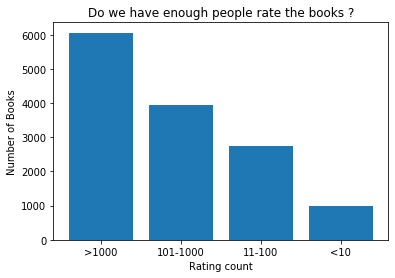

In [406]:
plt.bar(books['ratings_weight'].value_counts().index,books['ratings_weight'].value_counts())
plt.xlabel("Rating count")
plt.ylabel("Number of Books")
plt.title("Do we have enough people rate the books ?")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x141ce3c10>,
      dtype=object)

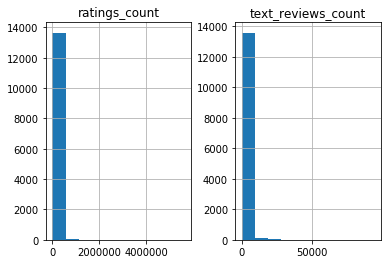

In [407]:
# The. data does not have text reviews  so 'text_reviews_count' may not be useful ,
#plus distribution matches the rating count  so we are going to use rating count 
# as a quantitattive measure for " how much did the user like a particular book"
books.hist(['ratings_count','text_reviews_count'])

### Average rating for the books

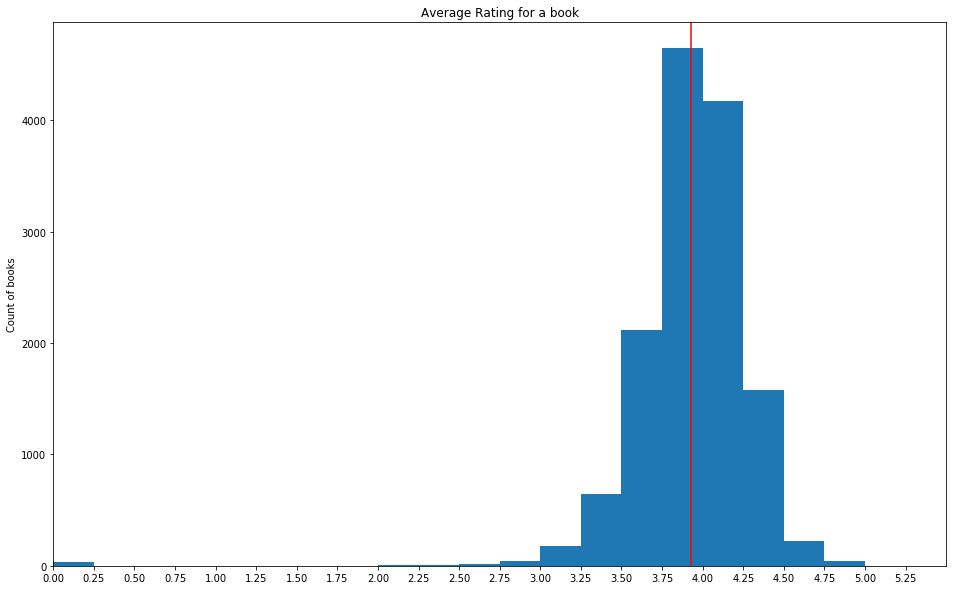

In [408]:
plt.figure(figsize=(16,10))
plt.hist(books['average_rating'], 20)
plt.gca().set(title='Average Rating for a book', ylabel='Count of books');
plt.xlim(0,5.5)
plt.xticks(np.arange(0, 5.5, step=0.25));
plt.axvline(books['average_rating'].mean(), color='r',label ="average length")

In [409]:
data=go.Scatter(x=books['ratings_count'] , # x data
                y=books['average_rating'] , # y data
                mode='markers' , # drawing mode for scatter trace
                #marker_color=books['title'] , # color by population
                marker_size= 12, # size of markers
                text=books['title'] ) # hover text goes here
layout = go.Layout(title ='Do People tend to rate book when they like book than when they dont?',
                   xaxis =dict(title='number of reviewers'),
                   yaxis =dict(title='overall rating'))
fig = go.Figure(data=data, layout=layout)
fig.show()

In [410]:
# TOP 10 books highly rated books
#books['average_rating'] >4.5 

#remove outliers?
books.head()

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,ratings_weight
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,652.0,1944099,26249,>1000
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,870.0,1996446,27613,>1000
2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,320.0,5629932,70390,>1000
3,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,352.0,6267,272,>1000
4,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,435.0,2149872,33964,>1000


In [1]:
books.to_csv("../data/cleaned_books.csv", index=False)

NameError: name 'books' is not defined

### Summary
We have around 13719 book reviews, from  7605 different authors.
1.We looked at the data to drop reduendent columns like , ISB13  and book ID, renamed. columns for consitency.
2. Number of Pages :
we have around 0.6% books with no book length.Most of the books were  196 to 421 pages.
The publishing industry doesn’t measure “books” in pages, but in word-count, 
in which case 50,000 is minimum requirement for a book with is 20 pages or so.
we should create feature with  4 categories for length of books
book_length   
 *0-20 - unknown,
 
 *21-195 - small
 
 *196 -420 - regular
 
 *421- 758 large
 
 *>758 - huge

3. Count of ratings
  rating bins?
3. Authors

### References

https://www.kaggle.com/jealousleopard/goodreadsbooks

https://www.kaggle.com/qwp8510/analyze-goodread-book-beginner-eda

install the Table of contents extension

https://github.com/minrk/ipython_extensions